<a href="https://colab.research.google.com/github/zlkhyr/NllbNusaX/blob/main/NllbClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install datasets
!pip install torchinfo

#Library

In [2]:
import torch
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
from torch.optim import AdamW
from google.colab import files
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, random_split
# from datasets import load_dataset, concatenate_datasets
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer
)

#Load Nllb

In [ ]:
model_name = "facebook/nllb-200-distilled-600M"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

#Data Preporocessing

In [42]:
train = pd.read_csv('/content/drive/MyDrive/Final_Year/data_train.csv')
val = pd.read_csv('/content/drive/MyDrive/Final_Year/data_val.csv')
test = pd.read_csv('/content/drive/MyDrive/Final_Year/data_test.csv')

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6000 non-null   object
 1   label   6000 non-null   object
 2   bahasa  6000 non-null   object
dtypes: object(3)
memory usage: 140.8+ KB


In [44]:
label_map = {"negative": 0, "neutral": 1, "positive": 2}
train["label"] = train["label"].map(label_map)
val["label"] = val["label"].map(label_map)
test["label"] = test["label"].map(label_map)

In [45]:
# map_bahasa ={
#   'aceh' : 'ace_Latn',
#   'bali' : 'ban_Latn',
#   'banjar' : 'bjn_Latn',
#   'bugis' : 'bug_Latn',
#   'indonesia' : 'ind_Latn',
#   'inggris' : 'eng_Latn',
#   'jawa' : 'jav_Latn',
#   'minang' : 'min_Latn',
#   'sunda' : 'sun_Latn',

#   'batak toba' : 'ind_Latn',
#   'madura' : 'ind_Latn',
#   'ngaju' : 'ind_Latn'
# }

In [46]:
def preprocess(dataset, shuffle):

  encoding = tokenizer(
      dataset['text'].tolist(),
      padding=True,
      truncation=True,
      max_length=model.config.max_length,
      return_tensors="pt"
  )

  labels = torch.tensor(dataset['label'].tolist(), dtype=torch.long)
  dataset = TensorDataset(encoding['input_ids'], encoding['attention_mask'], labels)
  dataloader = DataLoader(dataset, batch_size=32, shuffle=shuffle)
  return dataloader

In [47]:
train_dataloader = preprocess(train, True)
val_dataloader = preprocess(val, False)

## Preprocessing untuk dokumentasi

In [46]:
train['label_numerik'] = train['label'].map(label_map)

In [16]:
train[train.bahasa == 'indonesia'].head(10)

,text,label,bahasa,label_numerik
3500,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral,indonesia,1
3501,Kue-kue yang disajikan bikin saya bernostalgia...,positive,indonesia,2
3502,Ibu pernah bekerja di grab indonesia,neutral,indonesia,1
3503,Paling suka banget makan siang di sini ayam sa...,positive,indonesia,2
3504,Pelayanan bus DAMRI sangat baik,positive,indonesia,2
3505,Mau bikin postingan yang isinya mengedukasi cu...,neutral,indonesia,1
3506,Ratusan rumah di medan terendam banjir,neutral,indonesia,1
3507,"Barangnya lumayan, cuma yang saya heran xiaomi...",negative,indonesia,0
3508,Sulit sekali mempercayai orang yang sudah pern...,negative,indonesia,0
3509,"Lokasi di gombel dengan pemandangan semarang, ...",positive,indonesia,2


In [29]:
encoding = tokenizer(
    train['text'].tolist(),
    padding=True,
    truncation=True,
    max_length=tokenizer.model_max_length,
    return_tensors="pt"
)

In [18]:
for k, v in encoding.items():
  print(k,":\n",v)

input_ids :
 tensor([[256047,    909,   2244,  ...,      1,      1,      1],
        [256047,   1335,    407,  ...,      1,      1,      1],
        [256047,  52423,   3732,  ...,      1,      1,      1],
        ...,
        [256047, 171088,  11800,  ...,      1,      1,      1],
        [256047,   7432,   5103,  ...,      1,      1,      1],
        [256047,  23153,     96,  ...,      1,      1,      1]])
attention_mask :
 tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


In [20]:
labels = torch.tensor(train['label_numerik'].tolist(), dtype=torch.long)
labels

tensor([1, 2, 1,  ..., 2, 0, 0])

In [21]:
dataset = TensorDataset(encoding['input_ids'], encoding['attention_mask'], labels)

In [22]:
dataset.tensors

(tensor([[256047,    909,   2244,  ...,      1,      1,      1],
         [256047,   1335,    407,  ...,      1,      1,      1],
         [256047,  52423,   3732,  ...,      1,      1,      1],
         ...,
         [256047, 171088,  11800,  ...,      1,      1,      1],
         [256047,   7432,   5103,  ...,      1,      1,      1],
         [256047,  23153,     96,  ...,      1,      1,      1]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([1, 2, 1,  ..., 2, 0, 0]))

In [23]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [27]:
for batch in dataloader:
  print(batch[0] ,'\n', batch[1], '\n', batch[2])
  break

tensor([[256047,   3459,  23574,  ...,      1,      1,      1],
        [256047, 131631,   4587,  ...,      1,      1,      1],
        [256047,  29089,  69105,  ...,      1,      1,      1],
        ...,
        [256047,  41989,     13,  ...,      1,      1,      1],
        [256047,  39157,    969,  ...,      1,      1,      1],
        [256047, 197049,   6360,  ...,      1,      1,      1]]) 
 tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]) 
 tensor([0, 1, 0, 0, 1, 0, 2, 0, 1, 0, 0, 2, 2, 2, 2, 2, 0, 1, 0, 2, 0, 0, 0, 2,
        0, 0, 0, 0, 0, 0, 0, 2])


#Pengembangan Model

##Model NllbClassifier

In [48]:
class NllbClassifier(nn.Module):
    def __init__(self, encoder, num_labels=3):
        super().__init__()
        self.encoder = encoder #encoder dari NLLB model
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(encoder.config.hidden_size, num_labels)

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def forward(self, input_ids, attention_mask):
        #Menghapus spesial token di awal tiap text input (language token)
        input_ids = input_ids[:, 1:]
        attention_mask = attention_mask[:, 1:]

        #Forward pass ke encoder
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        # Pooling dengan attention_mask
        pooled_output = self.mean_pooling(outputs, attention_mask)

        # Dropout layer
        pooled_output = self.dropout(pooled_output)

        # Classification layer
        logits = self.classifier(pooled_output)

        return logits

#Model

In [49]:
encoder = model.get_encoder()

In [50]:
encoder

M2M100Encoder(
  (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
  (embed_positions): M2M100SinusoidalPositionalEmbedding()
  (layers): ModuleList(
    (0-11): 12 x M2M100EncoderLayer(
      (self_attn): M2M100Attention(
        (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (activation_fn): ReLU()
      (fc1): Linear(in_features=1024, out_features=4096, bias=True)
      (fc2): Linear(in_features=4096, out_features=1024, bias=True)
      (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
  )
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
)

In [51]:
modelFT = NllbClassifier(encoder, num_labels=3)

In [52]:
modelFT

NllbClassifier(
  (encoder): M2M100Encoder(
    (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
    (embed_positions): M2M100SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0-11): 12 x M2M100EncoderLayer(
        (self_attn): M2M100Attention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (activation_fn): ReLU()
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm((1024,), eps=1e-05, e

#Freezing



In [70]:
for param in modelFT.encoder.embed_tokens.parameters():
  param.requires_grad = False

#Training

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Code running di: {device}")

Code running di: cuda


In [54]:
modelFT.to(device)

NllbClassifier(
  (encoder): M2M100Encoder(
    (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
    (embed_positions): M2M100SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0-11): 12 x M2M100EncoderLayer(
        (self_attn): M2M100Attention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (activation_fn): ReLU()
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm((1024,), eps=1e-05, e

In [55]:
from torchinfo import summary
summary(modelFT)

Layer (type:depth-idx)                                  Param #
NllbClassifier                                          --
├─M2M100Encoder: 1-1                                    --
│    └─M2M100ScaledWordEmbedding: 2-1                   262,354,944
│    └─M2M100SinusoidalPositionalEmbedding: 2-2         --
│    └─ModuleList: 2-3                                  --
│    │    └─M2M100EncoderLayer: 3-1                     12,596,224
│    │    └─M2M100EncoderLayer: 3-2                     12,596,224
│    │    └─M2M100EncoderLayer: 3-3                     12,596,224
│    │    └─M2M100EncoderLayer: 3-4                     12,596,224
│    │    └─M2M100EncoderLayer: 3-5                     12,596,224
│    │    └─M2M100EncoderLayer: 3-6                     12,596,224
│    │    └─M2M100EncoderLayer: 3-7                     12,596,224
│    │    └─M2M100EncoderLayer: 3-8                     12,596,224
│    │    └─M2M100EncoderLayer: 3-9                     12,596,224
│    │    └─M2M100EncoderLaye

In [56]:
optimizer = AdamW([
    {'params': modelFT.encoder.parameters(), 'lr': 1e-5},
    {'params': modelFT.classifier.parameters(), 'lr': 5e-4},
])
loss_fn = nn.CrossEntropyLoss()

In [92]:
optimizer = AdamW(modelFT.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

In [57]:
history = {
        'train_loss':[],
        'val_loss':[],
        'train_acc':[],
        'val_acc':[]
    }

In [58]:
epochs = 10
patience = 3
best_val_loss = float('inf')
counter = 0

for epoch in range(epochs):
        modelFT.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs} [Train]", leave=False):
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = modelFT(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = correct_train / total_train
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)

        modelFT.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f"Epoch {epoch + 1}/{epochs} [Validation]", leave=False):
                input_ids, attention_mask, labels = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                outputs = modelFT(input_ids, attention_mask)
                loss = loss_fn(outputs, labels)

                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = correct_val / total_val
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Loss:{avg_train_loss:.4f}, Validation Loss:{avg_val_loss:.4f}, Accuracy:{train_accuracy:.2f}, Validation Accuracy:{val_accuracy:.2f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            torch.save(modelFT.state_dict(), 'best_model.pth')
        else:
            counter += 1
            print(f"Early stopping counter: {counter}/{patience}")
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

Epoch [1/10], Loss:0.7992, Validation Loss:0.6765, Accuracy:0.66, Validation Accuracy:0.72


Epoch [2/10], Loss:0.4938, Validation Loss:0.5856, Accuracy:0.81, Validation Accuracy:0.78


Epoch [3/10], Loss:0.3509, Validation Loss:0.5832, Accuracy:0.87, Validation Accuracy:0.78


Epoch [4/10], Loss:0.2534, Validation Loss:0.6541, Accuracy:0.91, Validation Accuracy:0.79
Early stopping counter: 1/3


Epoch [5/10], Loss:0.1866, Validation Loss:0.6882, Accuracy:0.93, Validation Accuracy:0.79
Early stopping counter: 2/3


Epoch [6/10], Loss:0.1372, Validation Loss:0.7813, Accuracy:0.95, Validation Accuracy:0.79
Early stopping counter: 3/3
Early stopping triggered at epoch 6


#Evaluation

In [59]:
def learning_curve(history, mode='loss'):
  plt.figure()
  if mode == 'loss':
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  elif mode == 'acc':
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Akurasi')
  plt.title(f'Learning Curve: {mode}')
  plt.legend()
  plt.grid(True)
  plt.show()

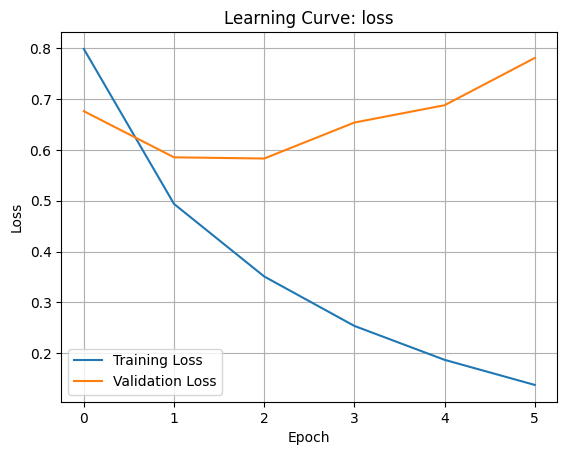

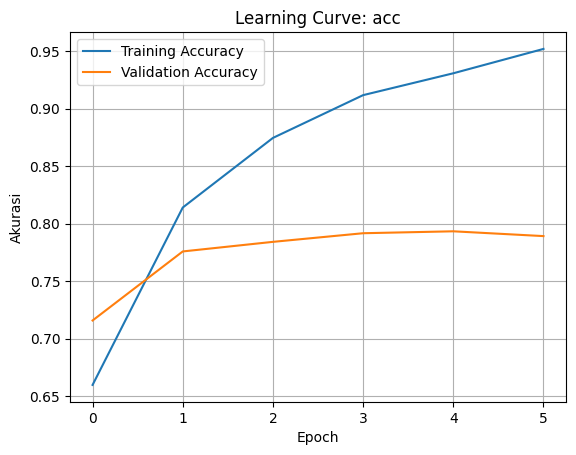

(None, None)

In [60]:
learning_curve(history, 'loss'), learning_curve(history, mode='acc')

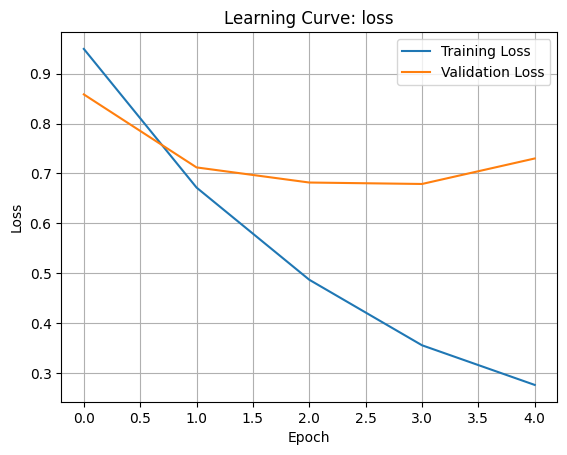

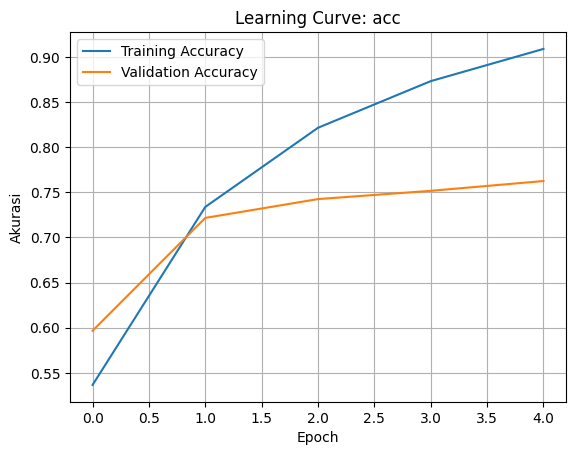

(None, None)

In [52]:
learning_curve(history, 'loss'), learning_curve(history, mode='acc')

In [61]:
test_dataloader = preprocess(test, False)

In [62]:
modelFT.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [63]:
modelFT.eval()
all_preds = []
all_labels = []

with torch.no_grad():
  for batch in tqdm(test_dataloader, desc=f"[Testing]", leave=False):
    input_ids, attention_mask, labels = batch
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    outputs = modelFT(input_ids, attention_mask)
    _, predicted = torch.max(outputs.data, 1)

    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

In [32]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1836
           1       0.77      0.73      0.75      1152
           2       0.83      0.88      0.85      1812

    accuracy                           0.81      4800
   macro avg       0.80      0.80      0.80      4800
weighted avg       0.80      0.81      0.80      4800



In [64]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1836
           1       0.78      0.75      0.77      1152
           2       0.86      0.86      0.86      1812

    accuracy                           0.81      4800
   macro avg       0.81      0.81      0.81      4800
weighted avg       0.81      0.81      0.81      4800



#test untuk tiap bahasa

In [65]:
test = pd.read_csv('/content/drive/MyDrive/Final_Year/data_test.csv')

In [66]:
test_ing = test[test.bahasa == 'aceh']

In [67]:
test_ing["label"] = test_ing["label"].map(label_map)

/tmp/ipython-input-3589811783.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ing["label"] = test_ing["label"].map(label_map)


In [68]:
test_ing

,text,label,bahasa
0,"Toe ngon hotel lon dom, jak ngon tapak, disino...",2,aceh
1,"Nyo beutoi, jih teungoh jaga warong.",1,aceh
2,On rumpunjih lumayan tapi bieng saos padang cu...,0,aceh
3,Meuteumpat di braga city walk nyang saboh geud...,2,aceh
4,Gianjar teurimong bantuan sosial dua ribe lapa...,1,aceh
...,...,...,...
395,Lon ka bit kayem pajoh bu di Rumoh Nenek. Lon ...,2,aceh
396,Le ureueng hana galak jak meuubat bak doto. Pe...,0,aceh
397,"Pelayanan get, teumpat peudong moto/honda pih ...",2,aceh
398,"Tes cpns punca macet, paloe",0,aceh


In [69]:
test_ing_dataloader = preprocess(test_ing, False)

In [70]:
modelFT.eval()
all_preds = []
all_labels = []

with torch.no_grad():
  for batch in tqdm(test_ing_dataloader, desc=f"[Testing]", leave=False):
    input_ids, attention_mask, labels = batch
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    outputs = modelFT(input_ids, attention_mask)
    _, predicted = torch.max(outputs.data, 1)

    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

In [40]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       153
           1       0.80      0.73      0.76        96
           2       0.82      0.87      0.85       151

    accuracy                           0.80       400
   macro avg       0.80      0.79      0.80       400
weighted avg       0.80      0.80      0.80       400



In [71]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       153
           1       0.82      0.78      0.80        96
           2       0.85      0.83      0.84       151

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400

